# Import and global variable

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
import datetime
now  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print(datetime.datetime.now())
print(now)

2020-05-20 20:23:59.883941
20200520_202359


In [3]:
xl_writer = pd.ExcelWriter(f"covid19_world_data_{now}.xlsx")

# Data

data from https://github.com/CSSEGISandData/COVID-19

or

https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

# Cases

In [4]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

In [5]:
df = pd.read_csv(url)

In [6]:
df.to_excel(xl_writer, "raw")

In [7]:
df.drop(columns=['Lat', 'Long'], inplace=True)

In [8]:
df.head()

,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653
1,NaN,Albania,0,0,0,0,0,0,0,0,...,868,872,876,880,898,916,933,946,948,949
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,755,755,758,760,761,761,761,761,761,761
4,NaN,Angola,0,0,0,0,0,0,0,0,...,45,45,45,45,48,48,48,48,50,52


In [9]:
countries = df["Country/Region"].unique()

In [10]:
countries.sort()

In [11]:
countries

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [12]:
province = df["Province/State"]

In [13]:
province.dropna(inplace=True)

In [14]:
province = province.unique()

In [15]:
province.sort()

In [16]:
province

array(['Alberta', 'Anguilla', 'Anhui', 'Aruba',
       'Australian Capital Territory', 'Beijing', 'Bermuda',
       'Bonaire, Sint Eustatius and Saba', 'British Columbia',
       'British Virgin Islands', 'Cayman Islands', 'Channel Islands',
       'Chongqing', 'Curacao', 'Diamond Princess',
       'Falkland Islands (Malvinas)', 'Faroe Islands', 'French Guiana',
       'French Polynesia', 'Fujian', 'Gansu', 'Gibraltar',
       'Grand Princess', 'Greenland', 'Guadeloupe', 'Guangdong',
       'Guangxi', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan',
       'Hong Kong', 'Hubei', 'Hunan', 'Inner Mongolia', 'Isle of Man',
       'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning', 'Macau', 'Manitoba',
       'Martinique', 'Mayotte', 'Montserrat', 'New Brunswick',
       'New Caledonia', 'New South Wales', 'Newfoundland and Labrador',
       'Ningxia', 'Northern Territory', 'Northwest Territories',
       'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Qinghai',
       'Quebec', 'Queensland

In [17]:
def extract_data(data_frame, country, region=None, groupby=False):
    if groupby:
        s = data_frame[data_frame["Country/Region"] == country].groupby(by=["Country/Region",]).sum().stack().droplevel(level=0)
    else:
        d = data_frame[(data_frame["Country/Region"] == country)]
        if region:
            s = d[d["Province/State"] == region].drop(columns=["Province/State", "Country/Region"]).stack().droplevel(level=0)

        else:
            s = d[d["Province/State"].isna()].drop(columns=["Province/State", "Country/Region"]).stack().droplevel(level=0)
    s.index = pd.to_datetime(s.index)
    df = s.to_frame()
    if region:
        df.columns = [region,]
    else:
        df.columns = [country,]
    df["day_of_year"] = df.index.dayofyear
    df.reset_index(inplace=True)
    df.columns = ['date'] + list(df.columns[1:])
    return df.set_index(['date', 'day_of_year'])

In [18]:
def plot_data(dataframe, logx=False, logy=False, **kwargs):
    if logx:
        df = dataframe.reset_index(level=0, drop=True)
        df.plot(logx=logx, logy=logy, **kwargs)
    else:
        df = dataframe.reset_index(level=1, drop=True)
        df.plot(logy=logy, **kwargs)
    plt.show()
            

In [19]:
def add(df1, df2, country):
    try:
        df = pd.concat([extract_data(df1, country), extract_data(df2, country)], axis=1)
    except KeyError:
        df = pd.concat([df1, df2], axis=1)
    df.country = country
    df.columns = ["cases", "deaths"]
    df["daily_cases"] = df["cases"].diff()
    df.loc[df["daily_cases"].isna(), "daily_cases"] = 0
    df["daily_cases_s"] = signal.savgol_filter(df["cases"], 11, 3, deriv=1)
    df["daily_death"] = df["deaths"].diff()
    df.loc[df["daily_death"].isna(), "daily_death"] = 0
    df["daily_death_s"] = signal.savgol_filter(df["deaths"], 11, 3, deriv=1)
    return df

In [20]:
def plot_daily(data):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 13))
    dataframe = data.copy()
    dataframe.reset_index("day_of_year", drop=True, inplace=True)
    dataframe["cases"].plot(color="r", 
                            title=f"Cases in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax1)
    dataframe["daily_cases"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax1)  
    dataframe["daily_cases_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax1)
    #
    dataframe["deaths"].plot(color="r", 
                            title=f"Deaths in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax2)
    dataframe["daily_death"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax2)  
    dataframe["daily_death_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax2)


# Switzerland

In [21]:
swiss = extract_data(df, "Switzerland")

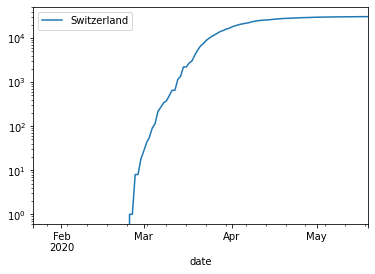

In [22]:
plot_data(swiss, logy=True)

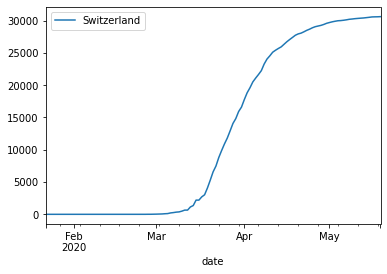

In [23]:
plot_data(swiss)

# Europe

In [24]:
italy = extract_data(df, "Italy")

In [25]:
france = extract_data(df, "France")

In [26]:
uk = extract_data(df, "United Kingdom")

In [27]:
spain = extract_data(df, "Spain")

In [28]:
germany =  extract_data(df, "Germany")

In [29]:
austria =  extract_data(df, "Austria")

In [30]:
europe = pd.concat([swiss, italy, france, germany, austria, spain, uk], axis=1)

In [31]:
# europe.columns = ['Switzerland', 'Italy', 'France', 'Germany', 'Austria', 'Spain', 'UK']

In [32]:
europe

,,Switzerland,Italy,France,Germany,Austria,Spain,United Kingdom
date,day_of_year,,,,,,,
2020-01-22,22,0,0,0,0,0,0,0
2020-01-23,23,0,0,0,0,0,0,0
2020-01-24,24,0,0,2,0,0,0,0
2020-01-25,25,0,0,3,0,0,0,0
2020-01-26,26,0,0,3,0,0,0,0
...,...,...,...,...,...,...,...,...
2020-05-15,136,30514,223885,177319,175233,16109,230183,236711
2020-05-16,137,30572,224760,177207,175752,16201,230698,240161
2020-05-17,138,30587,225435,177240,176369,16242,230698,243695


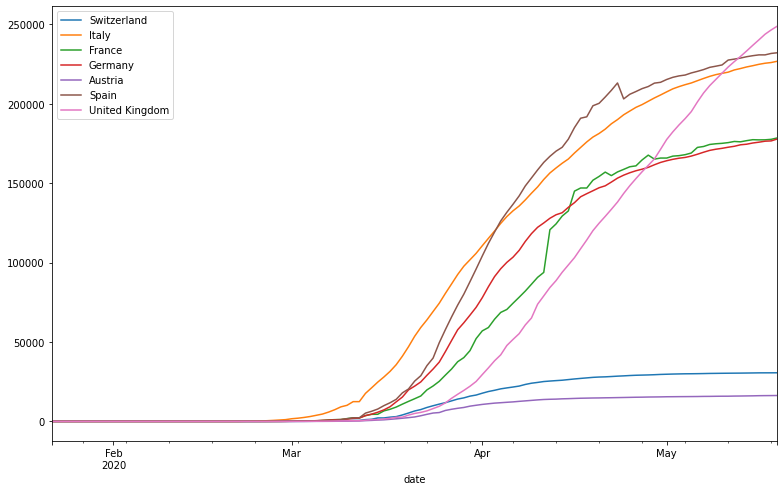

In [33]:
plot_data(europe, figsize=(13, 8))

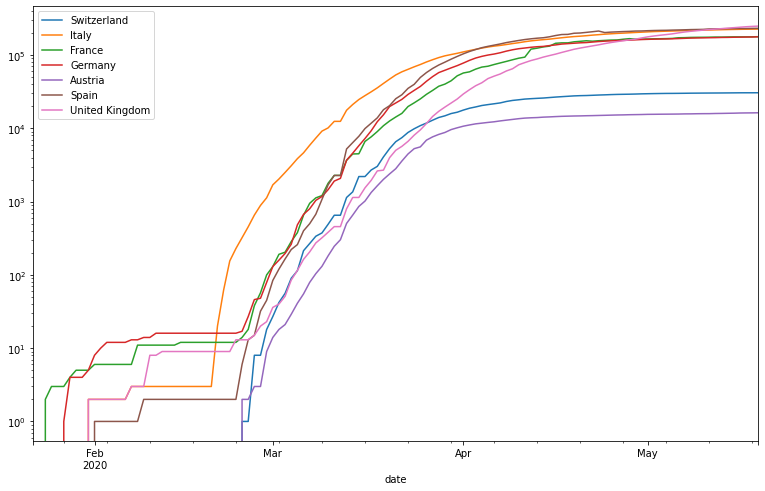

In [34]:
plot_data(europe, logy=True, figsize=(13, 8))

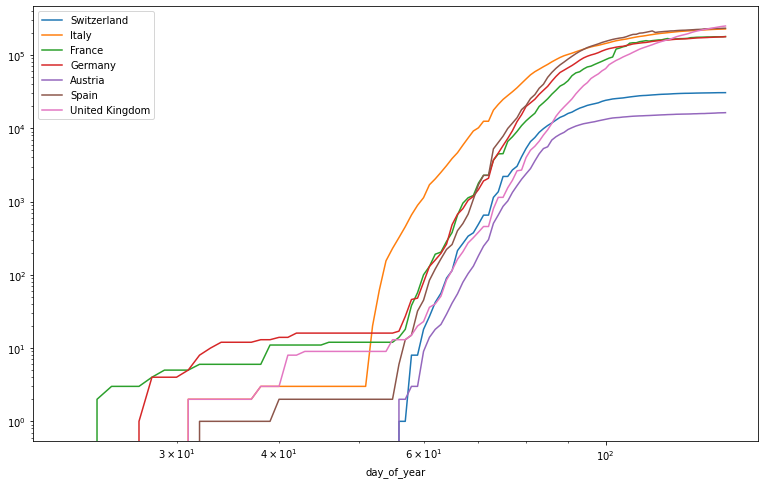

In [35]:
plot_data(europe, logy=True, logx=True, figsize=(13, 8))

# USA

In [36]:
us = extract_data(df, country="US", groupby=True)

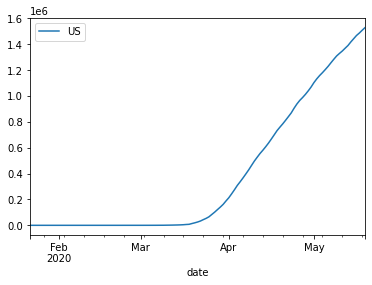

In [37]:
plot_data(us)

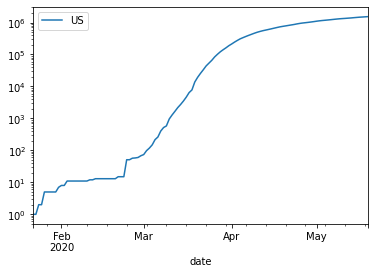

In [38]:
plot_data(us, logy=True)

# Europe + USA

In [39]:
comp_us = pd.concat([europe, us], axis=1)

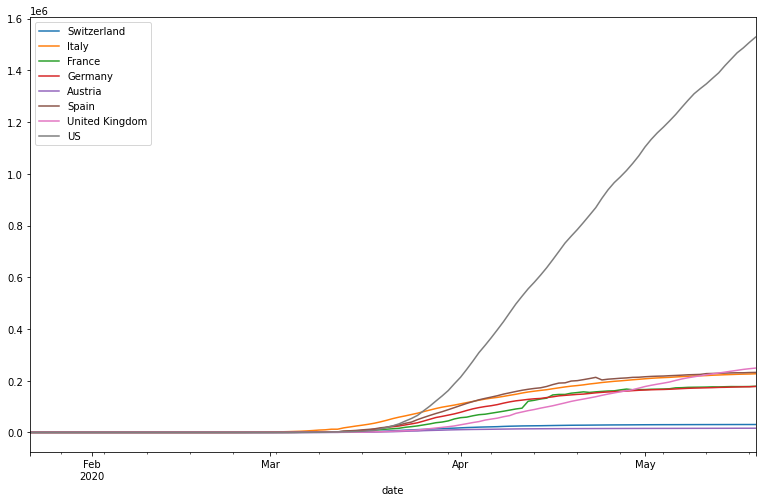

In [40]:
plot_data(comp_us, figsize=(13, 8))

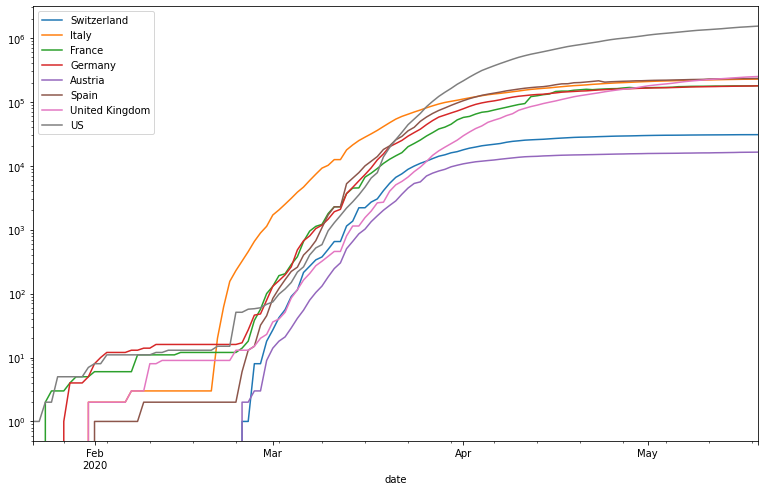

In [41]:
plot_data(comp_us, logy=True, figsize=(13, 8))

# Worldwide

In [42]:
world = df.sum(axis=0).drop(index=['Country/Region']).to_frame()

In [43]:
world.index = pd.to_datetime(world.index)

In [44]:
world["day_of_year"] = world.index.dayofyear

In [45]:
world.reset_index(inplace=True)

In [46]:
world.columns = ["date", "world_cases", "day_of_year"]

In [47]:
world.set_index(["date", "day_of_year"], inplace=True)

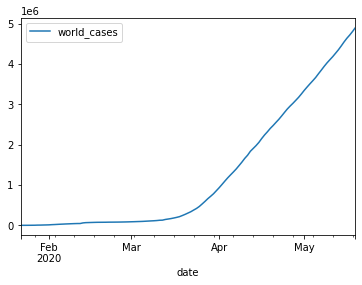

In [48]:
plot_data(world)

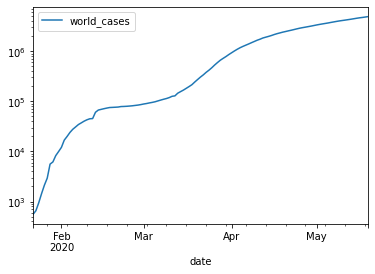

In [49]:
plot_data(world, logy=True)

# Iran

In [50]:
iran = extract_data(df, "Iran")

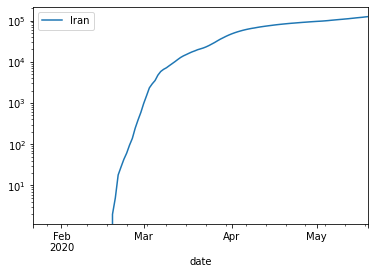

In [51]:
plot_data(iran, logy=True)

In [52]:
comp_iran = pd.concat([comp_us, iran], axis=1)

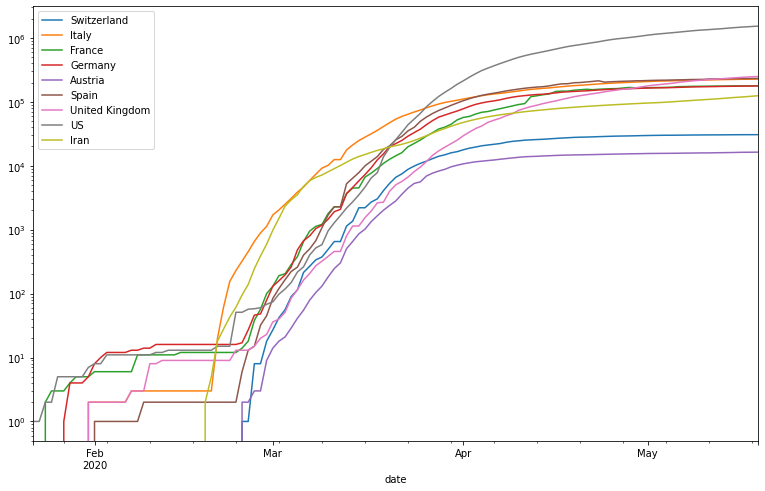

In [53]:
plot_data(comp_iran, logy=True, figsize=(13, 8))

# China

In [54]:
china = extract_data(df, "China", groupby=True)

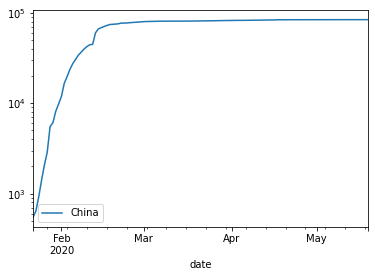

In [55]:
plot_data(china, logy=True)

In [56]:
comp_china = pd.concat([china, comp_us], axis=1)

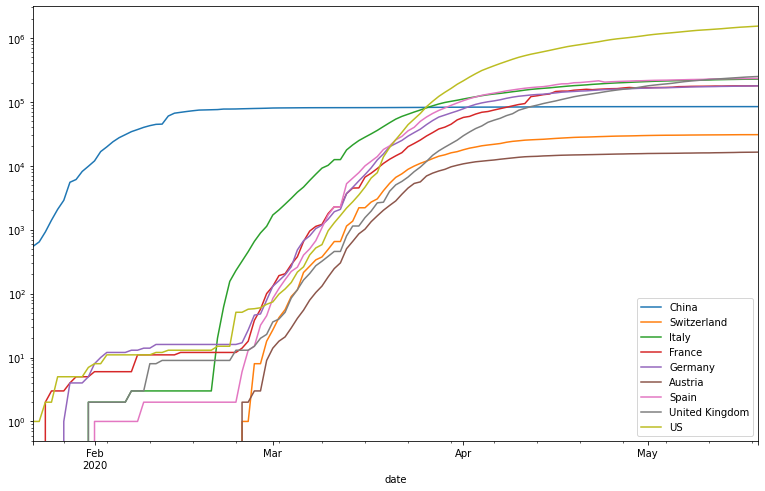

In [57]:
plot_data(comp_china, logy=True, figsize=(13, 8))

# Shanghai

In [58]:
shanghai = extract_data(df, "China", "Shanghai")

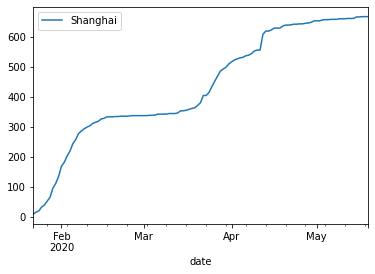

In [59]:
plot_data(shanghai)

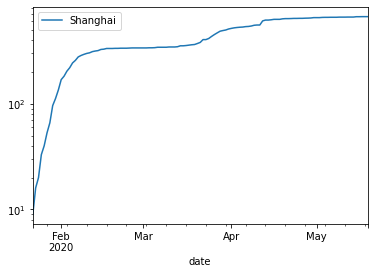

In [60]:
plot_data(shanghai, logy=True)

# Singapore

In [61]:
singapore = extract_data(df, "Singapore")

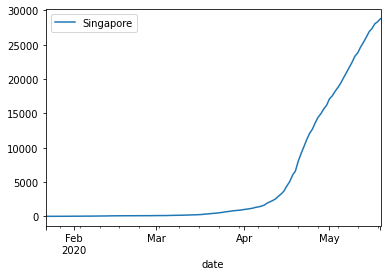

In [62]:
plot_data(singapore)

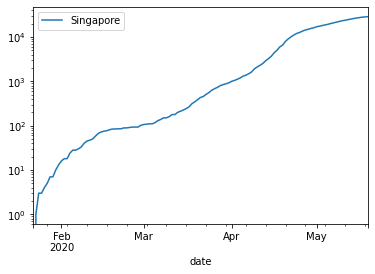

In [63]:
plot_data(singapore, logy=True)

# South Korea

In [64]:
kr = extract_data(df, "Korea, South")

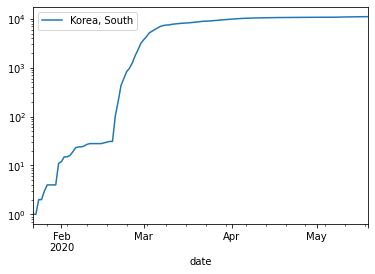

In [65]:
plot_data(kr, logy=True)

# South Central China

## Hong Kong

In [66]:
hong_kong = extract_data(df,"China", "Hong Kong")

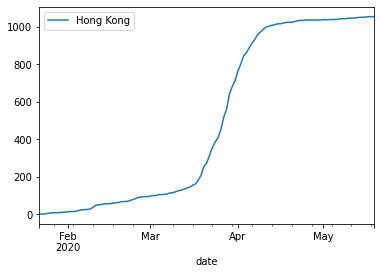

In [67]:
plot_data(hong_kong)

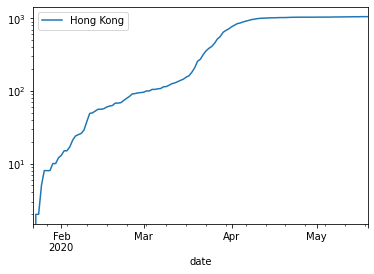

In [68]:
plot_data(hong_kong, logy=True)

## Hubei (Wuhan)

In [69]:
hubei = extract_data(df,"China", "Hubei")

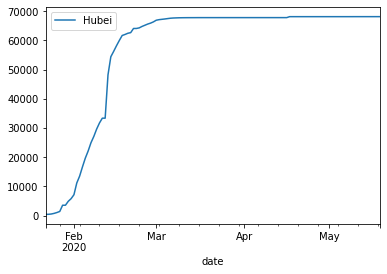

In [70]:
plot_data(hubei)

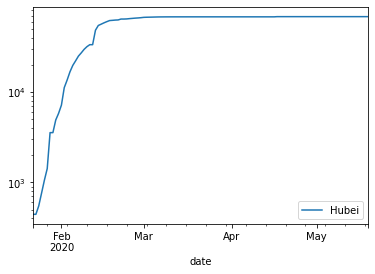

In [71]:
plot_data(hubei, logy=True)

## Henan

In [72]:
henan = extract_data(df, "China", "Henan")

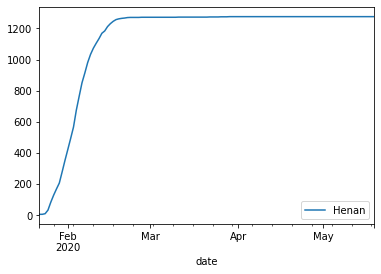

In [73]:
plot_data(henan)

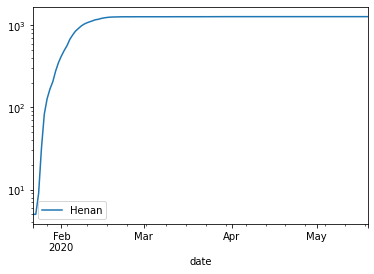

In [74]:
plot_data(henan, logy=True)

## Hunan

In [75]:
hunan = extract_data(df, "China", "Hunan")

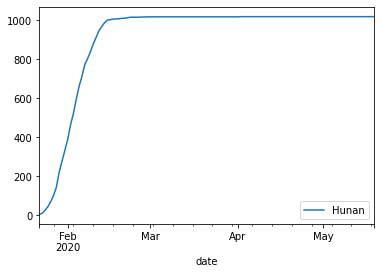

In [76]:
plot_data(hunan)

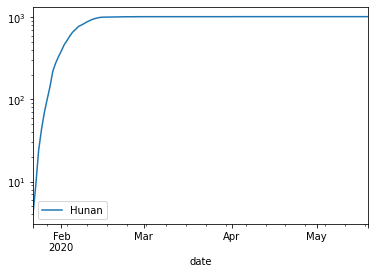

In [77]:
plot_data(hunan, logy=True)

## Guangdong

In [78]:
guangdong = extract_data(df, "China", "Guangdong")

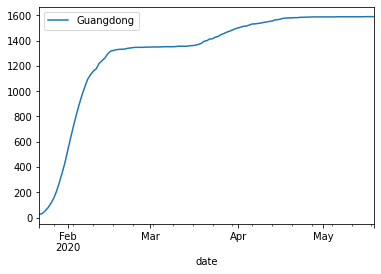

In [79]:
plot_data(guangdong)

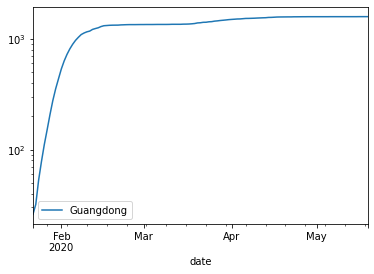

In [80]:
plot_data(guangdong, logy=True)

## Guangxi

In [81]:
guangxi = extract_data(df, "China", "Guangxi")

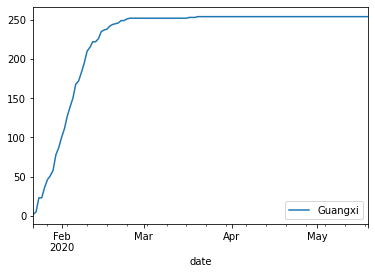

In [82]:
plot_data(guangxi)

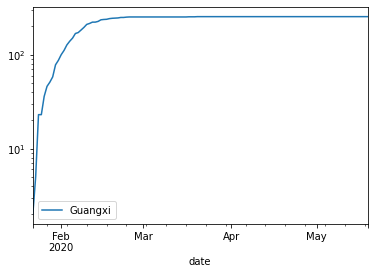

In [83]:
plot_data(guangxi, logy=True)

# South-Asia

In [84]:
south_asia = pd.concat([singapore, hong_kong, shanghai, kr, italy], axis=1)

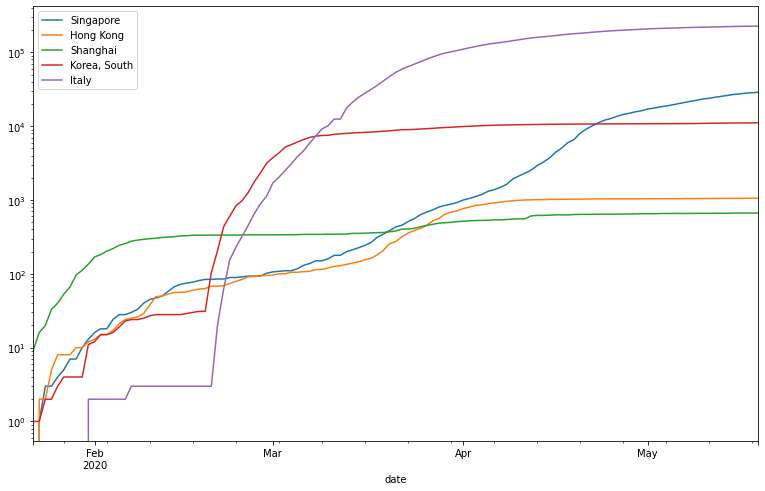

In [85]:
plot_data(south_asia, logy=True, figsize=(13, 8))

# North Europe

In [86]:
sweden = extract_data(df, "Sweden")

In [87]:
norway = extract_data(df, "Norway")

In [88]:
danemark = extract_data(df, 'Danemark')

In [89]:
finland = extract_data(df, 'Finland')

In [90]:
nl = extract_data(df, "Netherlands")

In [91]:
nort_eu = pd.concat([swiss, germany, sweden, norway, danemark, finland, nl], axis=1)

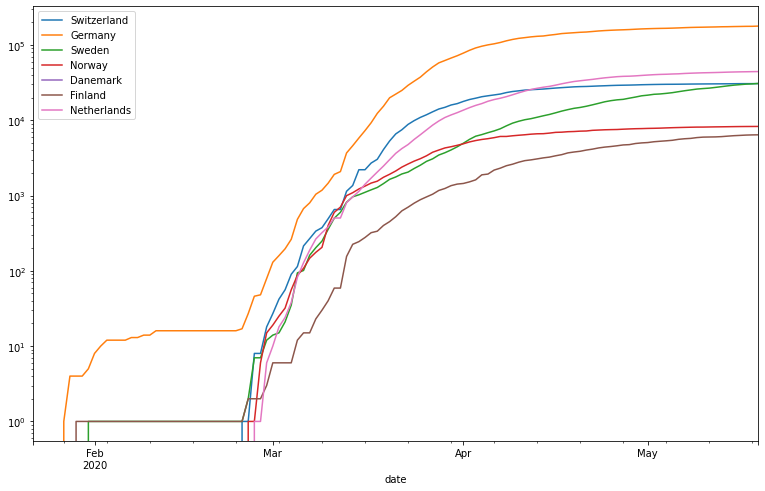

In [92]:
plot_data(nort_eu, logy=True, figsize=(13, 8))

# Death

In [93]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [94]:
death = pd.read_csv(url)

In [95]:
death.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,120,122,127,132,136,153,168,169,173,178
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,31,31,31,31,31,31,31,31,31,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,502,507,515,522,529,536,542,548,555,561
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,48,48,48,49,49,49,51,51,51,51
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,3,3


In [96]:
death.drop(columns=['Lat', 'Long'], inplace=True)

In [97]:
uk_death = extract_data(death, "United Kingdom")

In [98]:
us_death = extract_data(death, "US", groupby=True)

In [99]:
it_death = extract_data(death, "Italy")

In [100]:
es_death = extract_data(death, "Spain")

In [101]:
de_death = extract_data(death, "Germany")

In [102]:
cn_death = extract_data(death, "China", groupby=True)

In [103]:
fr_death = extract_data(death, "France")

In [104]:
ch_death = extract_data(death, "Switzerland")

In [105]:
comp_death = pd.concat([it_death, uk_death, us_death, es_death, de_death, cn_death, ch_death, fr_death], axis=1)

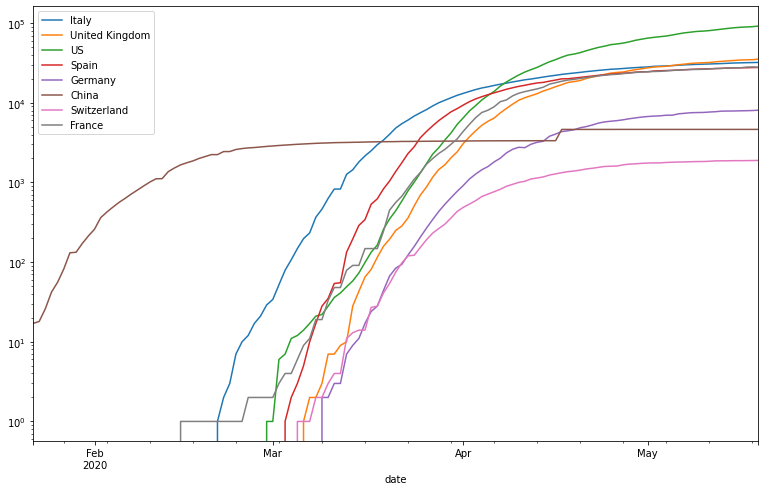

In [106]:
plot_data(comp_death, logy=True, figsize=(13, 8))

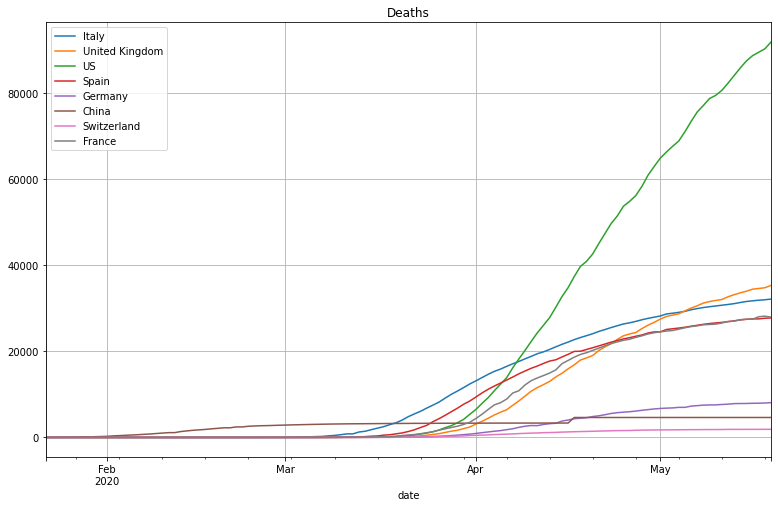

In [107]:
plot_data(comp_death, figsize=(13, 8), title="Deaths", grid=True)

In [108]:
world_death = death.sum(axis=0).drop(index=['Country/Region']).to_frame()

In [109]:
world_death.index = pd.to_datetime(world_death.index)

In [110]:
world_death["day_of_year"] = world_death.index.dayofyear

In [111]:
world_death.reset_index(inplace=True)

In [112]:
world_death.columns = ["date", "world_death", "day_of_year"]

In [113]:
world_death.set_index(["date", "day_of_year"], inplace=True)

In [114]:
comp_world = add(world, world_death, "World")

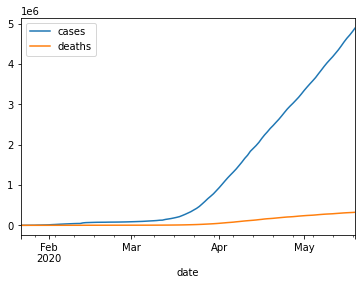

In [115]:
plot_data(comp_world[["cases", "deaths"]])

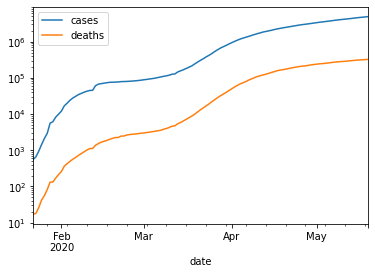

In [116]:
plot_data(comp_world[["cases", "deaths"]], logy=True)

In [117]:
comp_world.to_excel(xl_writer, "World")

In [118]:
xl_writer.close()

In [119]:
df_summary_cases = pd.DataFrame(df[["Country/Region", df.columns[-1]]].groupby(by="Country/Region").sum().to_records())

In [120]:
df_summary_cases.columns = ["Country", "Cases"]

In [121]:
df_summary_deaths = pd.DataFrame(death[["Country/Region", death.columns[-1]]].groupby(by="Country/Region").sum().to_records())

In [122]:
df_summary_deaths.columns = ["Country", "Deaths"]

In [123]:
df_summary = pd.merge(df_summary_cases, df_summary_deaths, how="outer", on="Country")

In [124]:
iso_code = pd.read_csv("country_name_to_iso_code.csv")
iso_code.loc[iso_code["Country"] == "Namibia", "alpha-2"] = "NA"
iso_code[iso_code["Country"] == "Namibia"]

,Unnamed: 0,Country,alpha-2
150,152,Namibia,NA


In [125]:
df_summary = pd.merge(df_summary, iso_code, how="outer", on="Country")
df_summary.drop(columns=["Unnamed: 0", ], inplace=True)

In [126]:
df_summary.sort_values(by=["Cases",], ascending=False)

,Country,Cases,Deaths,alpha-2
174,US,1528568.0,91921.0,US
140,Russia,299941.0,2837.0,RU
23,Brazil,271885.0,17983.0,BR
178,United Kingdom,250138.0,35422.0,GB
158,Spain,232037.0,27778.0,ES
...,...,...,...,...
245,Tuvalu,NaN,NaN,TV
246,U.S. Virgin Islands,NaN,NaN,VI
247,United States,NaN,NaN,US
248,Vanuatu,NaN,NaN,VU


In [127]:
number_of_countries = 15

In [128]:
by_countries = df_summary.copy().drop(columns="alpha-2").set_index("Country")

In [129]:
by_countries.sort_values(by="Cases", ascending=False, inplace=True)

In [130]:
by_countries.head(20)

,Cases,Deaths
Country,,
US,1528568.0,91921.0
Russia,299941.0,2837.0
Brazil,271885.0,17983.0
United Kingdom,250138.0,35422.0
Spain,232037.0,27778.0
Italy,226699.0,32169.0
France,180933.0,28025.0
Germany,177778.0,8081.0
Turkey,151615.0,4199.0


In [131]:
[by_countries.iloc[:number_of_countries].sum(), ]

[Cases     3874565.0
 Deaths     272745.0
 dtype: float64]

In [132]:
by_countries = pd.concat([
    by_countries.iloc[:number_of_countries],
    pd.DataFrame([by_countries.iloc[number_of_countries:].sum(), ])
]
)

In [133]:
by_countries.rename(index={0: 'others'}, inplace=True)

In [134]:
by_countries

,Cases,Deaths
US,1528568.0,91921.0
Russia,299941.0,2837.0
Brazil,271885.0,17983.0
United Kingdom,250138.0,35422.0
Spain,232037.0,27778.0
Italy,226699.0,32169.0
France,180933.0,28025.0
Germany,177778.0,8081.0
Turkey,151615.0,4199.0
Iran,124603.0,7119.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b5ecf5d90>,
      dtype=object)

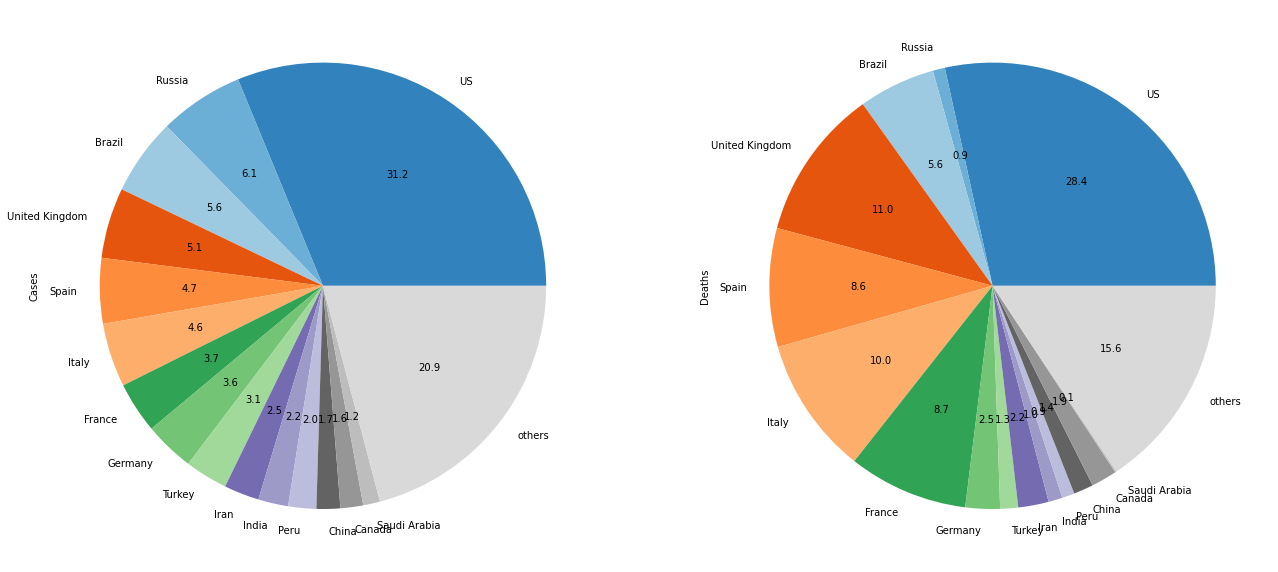

In [181]:
by_countries.plot.pie(subplots=True, figsize=(22, 11), cmap=plt.cm.get_cmap('tab20c'), legend=False, autopct='%.1f')

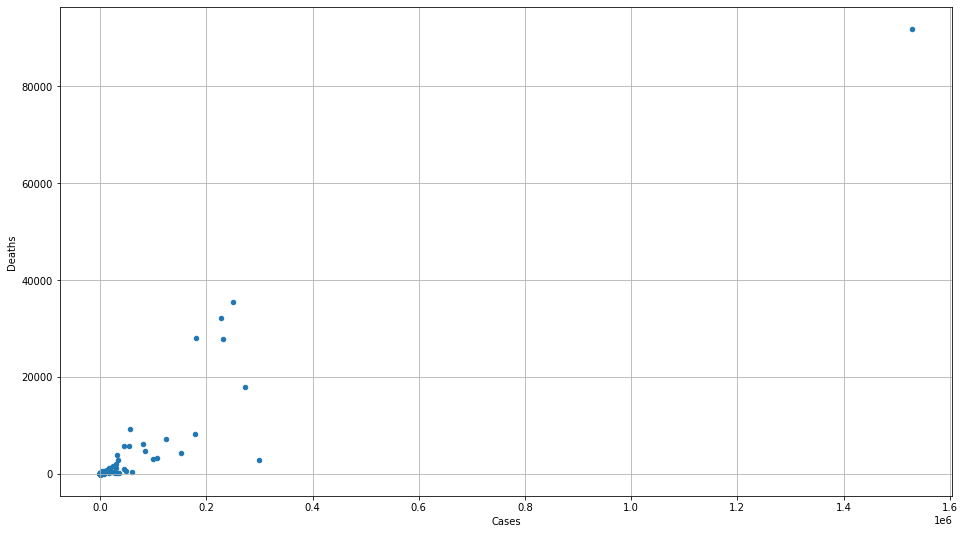

In [136]:
df_summary.plot.scatter(x="Cases", y="Deaths", figsize=(16, 9), grid=True)

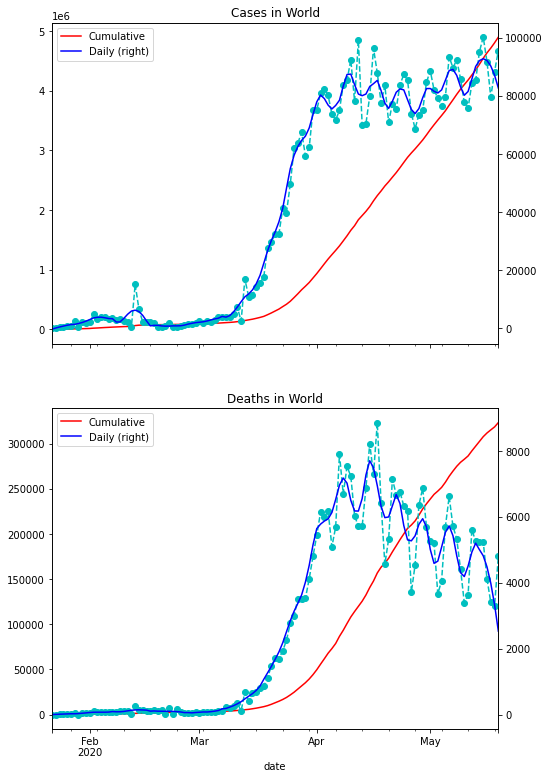

In [137]:
plot_daily(comp_world)

In [138]:
se = add(df, death, "Sweden")

In [139]:
uk = add(df, death, "United Kingdom")

In [140]:
it = add(df, death, "Italy")

In [141]:
sp = add(df, death, "Spain")

In [142]:
fr = add(df, death, "France")

In [143]:
ch = add(df, death, "Switzerland")

In [144]:
be = add(df, death, "Belgium")

In [145]:
de = add(df, death, "Germany")

In [146]:
kr = add(df, death, "Korea, South")

In [147]:
nl = add(df, death, "Netherlands")

In [148]:
us = add(df, death, "US")

In [149]:
sg = add(df, death, "Singapore")

In [150]:
br = add(df, death, "Brazil")

In [151]:
pe = add(df, death, "Peru")

In [152]:
ru = add(df, death, "Russia")

In [153]:
tu = add(df, death, "Turkey")

In [154]:
ir = add(df, death, "Iran")

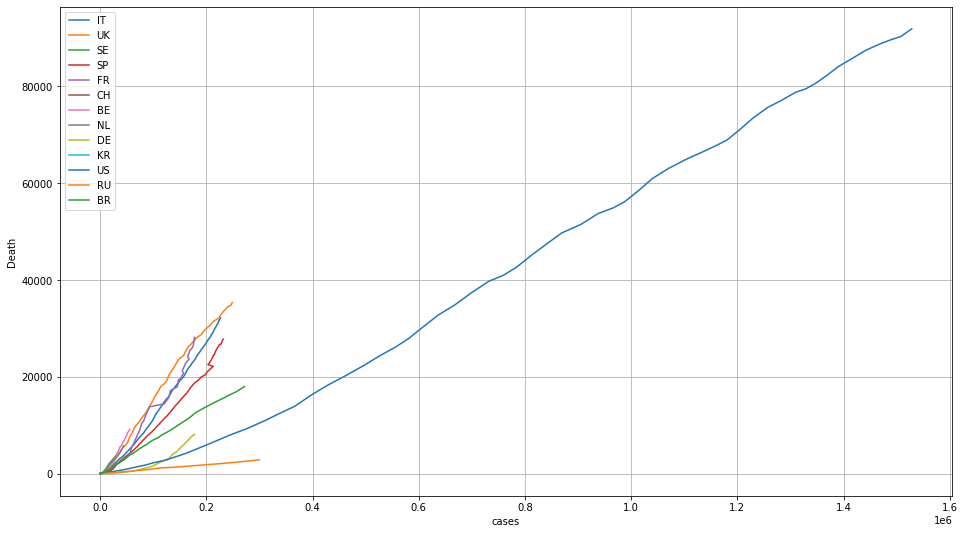

In [155]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_ylabel("Death")
it.plot(x="cases", y="deaths", ax=ax, grid=True, label="IT")
uk.plot(x="cases", y="deaths", ax=ax, grid=True, label="UK")
se.plot(x="cases", y="deaths", ax=ax, grid=True, label="SE")
sp.plot(x="cases", y="deaths", ax=ax, grid=True, label="SP")
fr.plot(x="cases", y="deaths", ax=ax, grid=True, label="FR")
ch.plot(x="cases", y="deaths", ax=ax, grid=True, label="CH")
be.plot(x="cases", y="deaths", ax=ax, grid=True, label="BE")
nl.plot(x="cases", y="deaths", ax=ax, grid=True, label="NL")
de.plot(x="cases", y="deaths", ax=ax, grid=True, label="DE")
kr.plot(x="cases", y="deaths", ax=ax, grid=True, label="KR")
us.plot(x="cases", y="deaths", ax=ax, grid=True, label="US")
ru.plot(x="cases", y="deaths", ax=ax, grid=True, label="RU")
br.plot(x="cases", y="deaths", ax=ax, grid=True, label="BR")

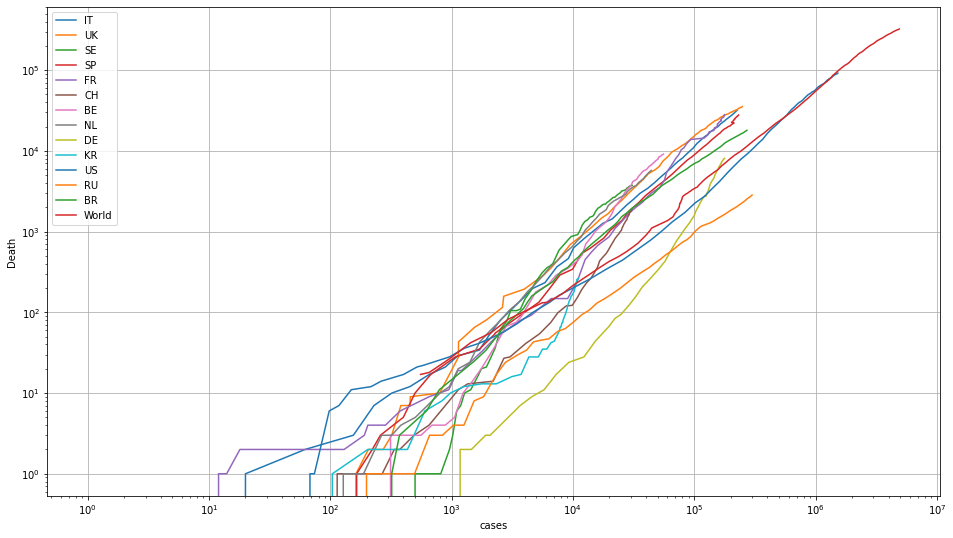

In [156]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_ylabel("Death")
it.plot(x="cases", y="deaths", ax=ax, grid=True, label="IT", loglog=True)
uk.plot(x="cases", y="deaths", ax=ax, grid=True, label="UK")
se.plot(x="cases", y="deaths", ax=ax, grid=True, label="SE")
sp.plot(x="cases", y="deaths", ax=ax, grid=True, label="SP")
fr.plot(x="cases", y="deaths", ax=ax, grid=True, label="FR")
ch.plot(x="cases", y="deaths", ax=ax, grid=True, label="CH")
be.plot(x="cases", y="deaths", ax=ax, grid=True, label="BE")
nl.plot(x="cases", y="deaths", ax=ax, grid=True, label="NL")
de.plot(x="cases", y="deaths", ax=ax, grid=True, label="DE")
kr.plot(x="cases", y="deaths", ax=ax, grid=True, label="KR")
us.plot(x="cases", y="deaths", ax=ax, grid=True, label="US")
ru.plot(x="cases", y="deaths", ax=ax, grid=True, label="RU")
br.plot(x="cases", y="deaths", ax=ax, grid=True, label="BR")
comp_world.plot(x="cases", y="deaths", ax=ax, grid=True, label="World")

In [157]:
by_countries.index

Index(['US', 'Russia', 'Brazil', 'United Kingdom', 'Spain', 'Italy', 'France',
       'Germany', 'Turkey', 'Iran', 'India', 'Peru', 'China', 'Canada',
       'Saudi Arabia', 'others'],
      dtype='object')

In [158]:
def plot_daily(data):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 13))
    dataframe = data.copy()
    dataframe.reset_index("day_of_year", drop=True, inplace=True)
    dataframe["cases"].plot(color="r", 
                            title=f"Cases in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax1)
    ax11 = dataframe["daily_cases"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax1)  
    dataframe["daily_cases_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax1)
    ax1.set_ylabel("Cumulative cases")
    ax11.set_ylabel("Daily Cases")
    #
    dataframe["deaths"].plot(color="r", 
                            title=f"Deaths in {data.country}", 
                            legend=True, 
                            label="Cumulative",
                           ax=ax2)
    ax22 = dataframe["daily_death"].plot(secondary_y=True, style="co--", rot=0, legend=True, label="Daily", ax=ax2)  
    dataframe["daily_death_s"].plot(secondary_y=True, color="b", rot=0, legend=True, label="Daily 2", ax=ax2)
    ax2.set_ylabel("Cumulative cases")
    ax22.set_ylabel("Daily deaths")

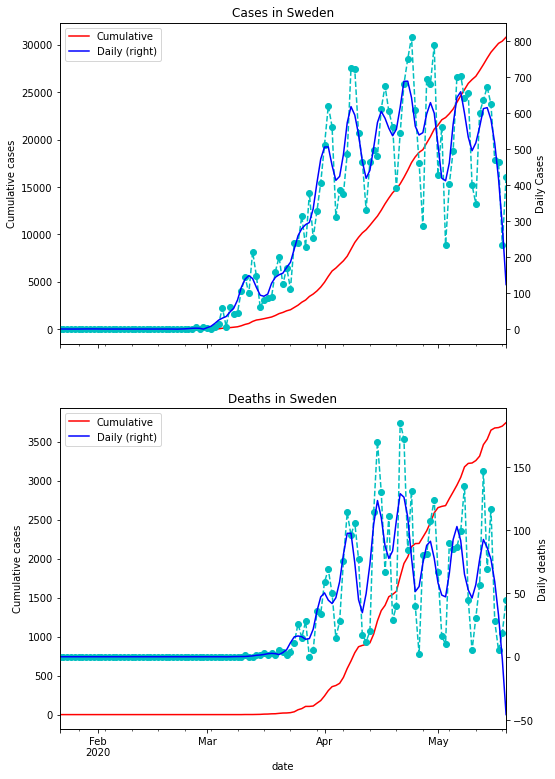

In [159]:
plot_daily(se)

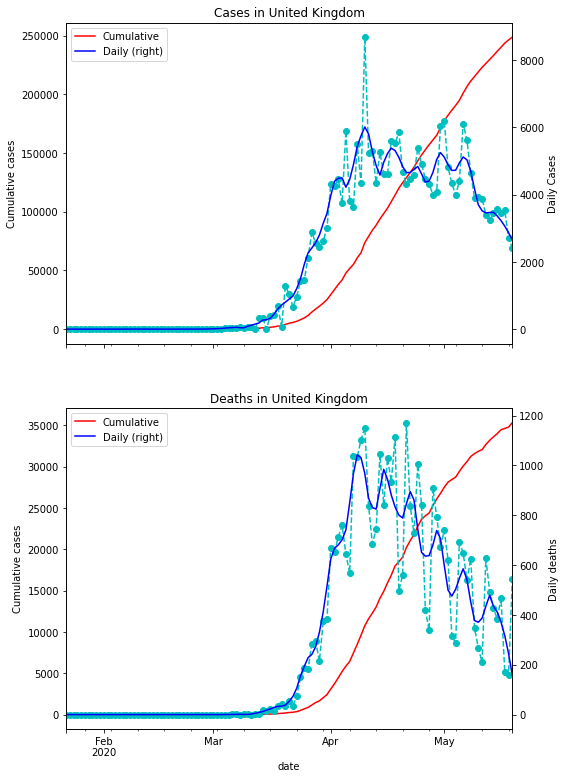

In [160]:
plot_daily(uk)

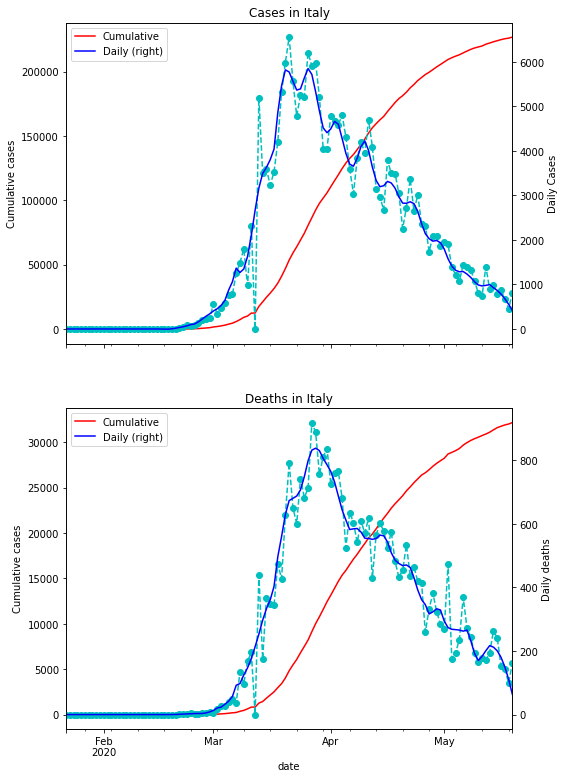

In [161]:
plot_daily(it)

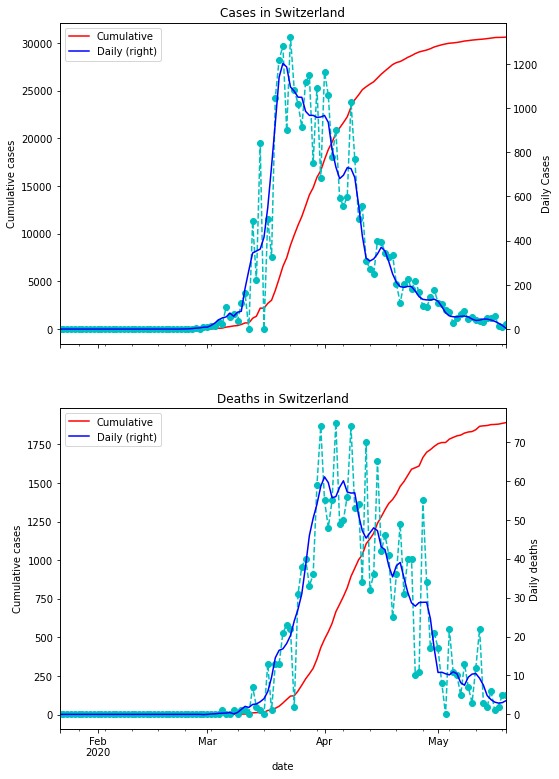

In [162]:
plot_daily(ch)

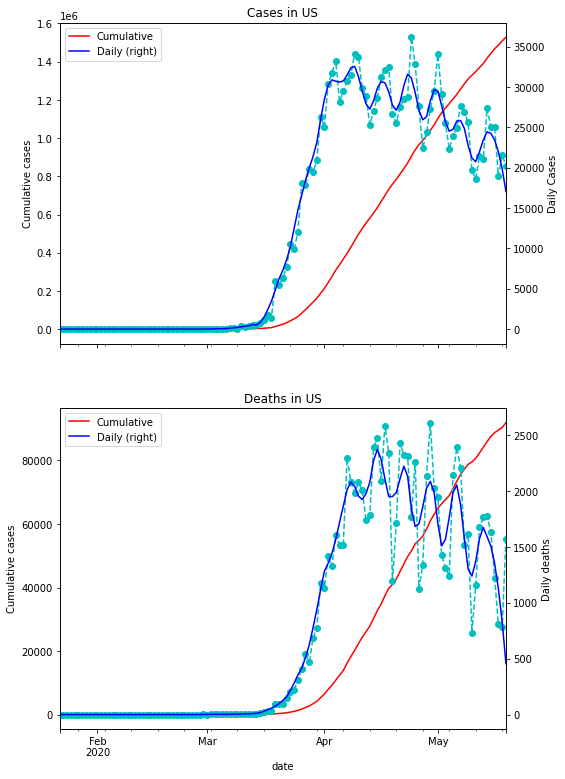

In [163]:
plot_daily(us)

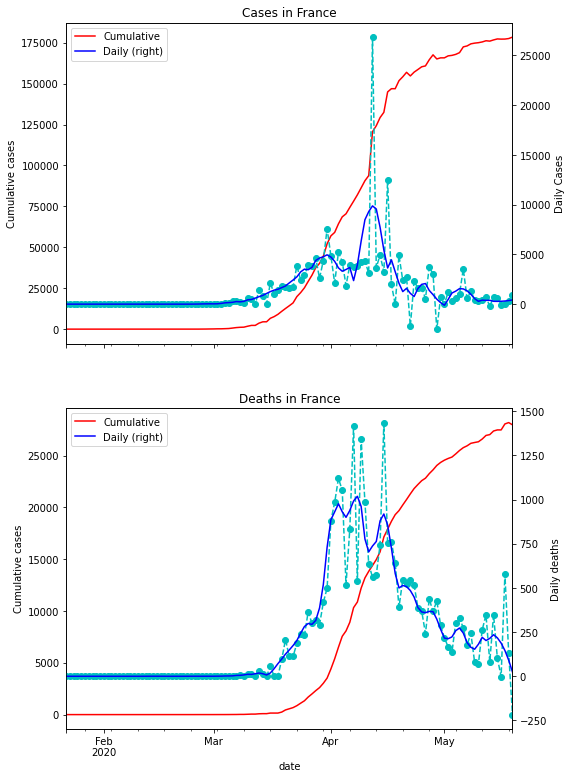

In [164]:
plot_daily(fr)

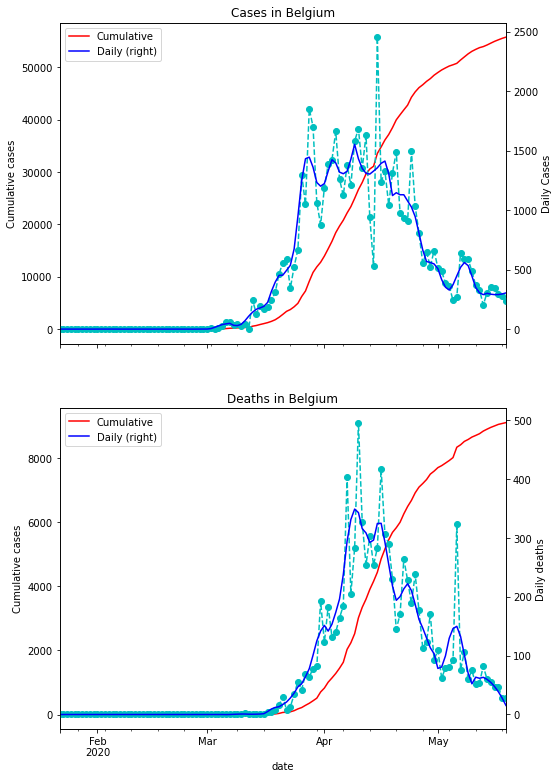

In [165]:
plot_daily(be)

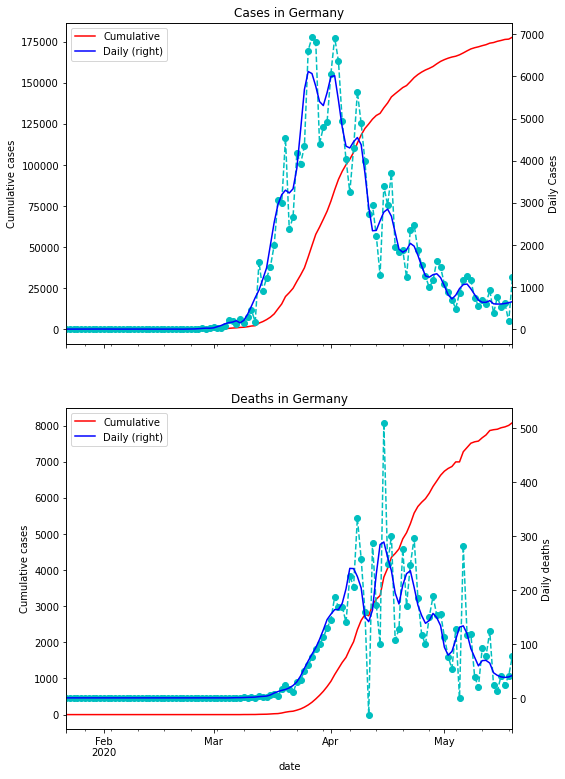

In [166]:
plot_daily(de)

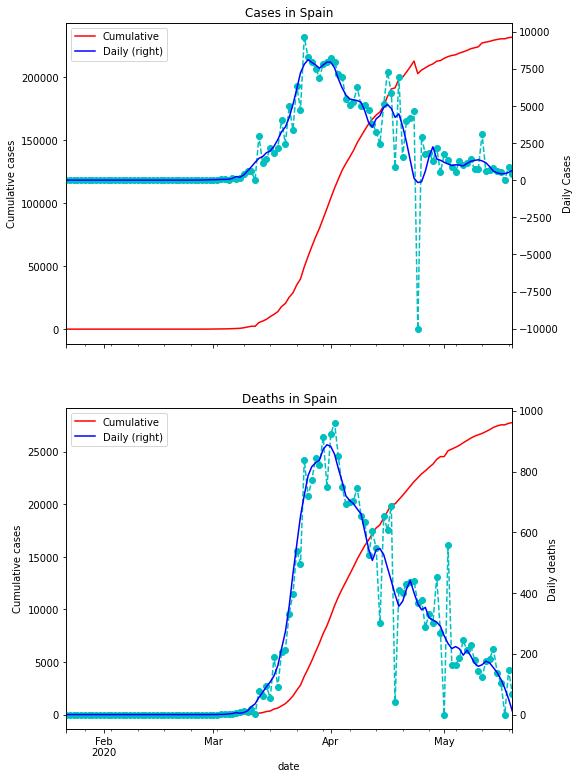

In [167]:
plot_daily(sp)

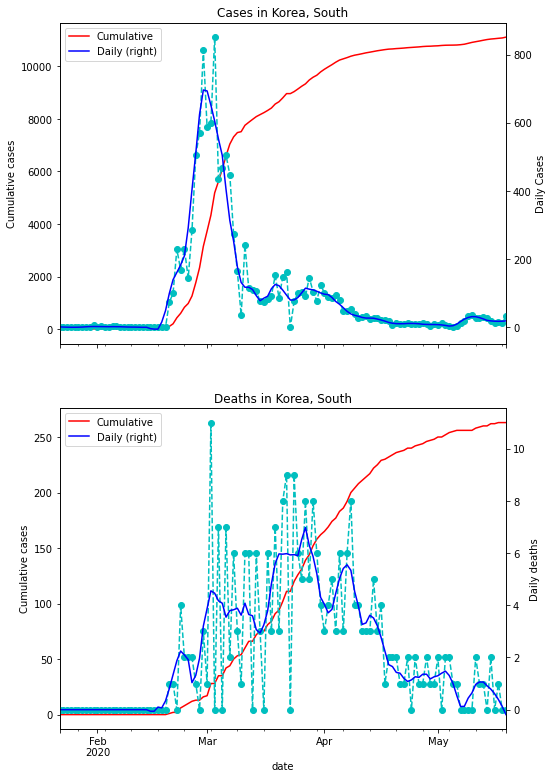

In [168]:
plot_daily(kr)

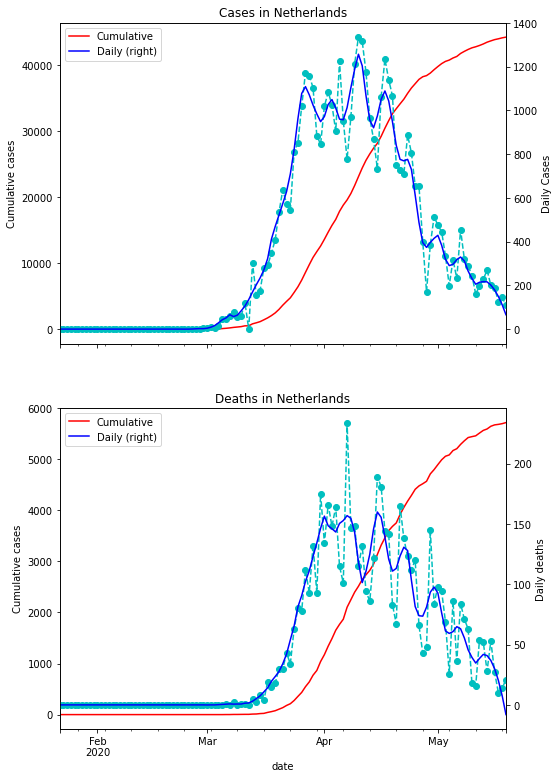

In [169]:
plot_daily(nl)

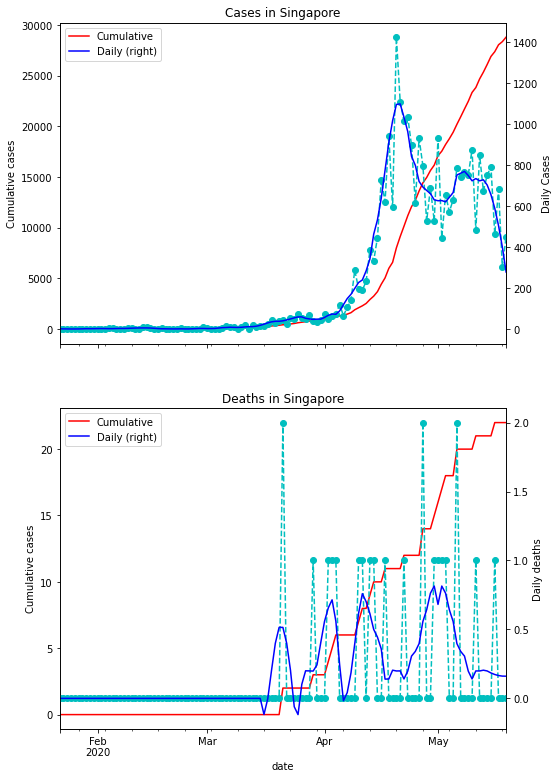

In [170]:
plot_daily(sg)

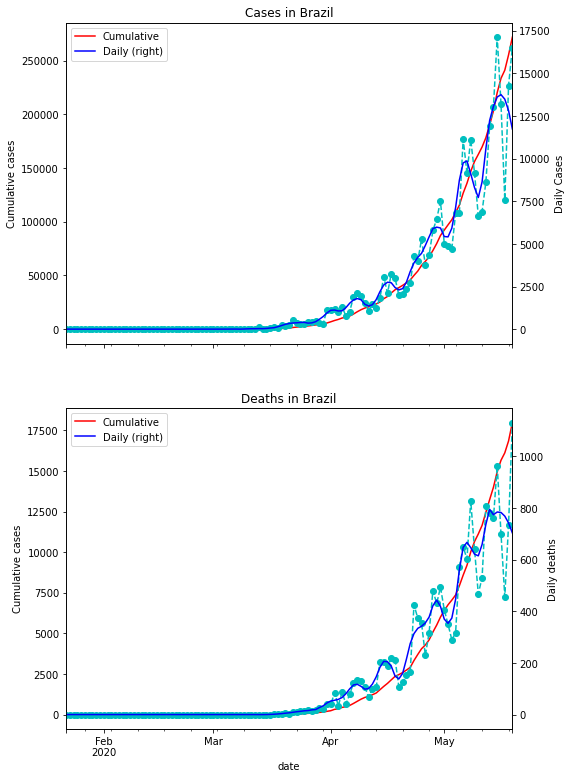

In [171]:
plot_daily(br)

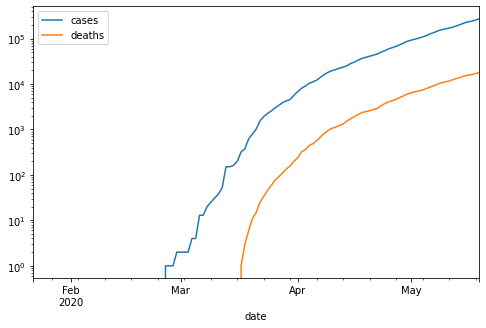

In [172]:
plot_data(br[["cases", "deaths"]], logy=True, figsize=(8, 5))

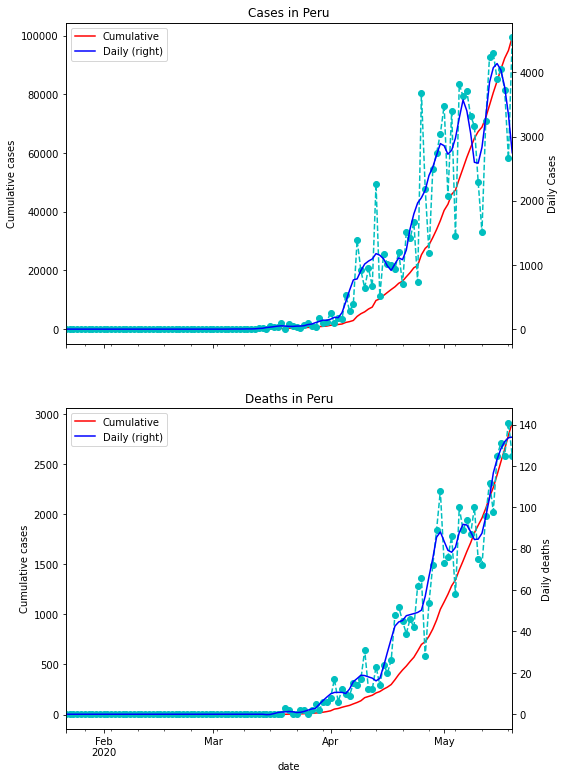

In [173]:
plot_daily(pe)

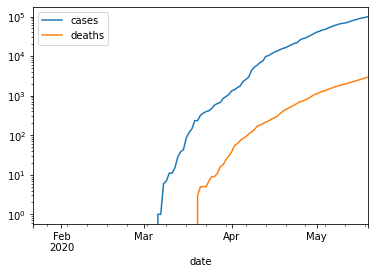

In [174]:
plot_data(pe[["cases", "deaths"]], logy=True)

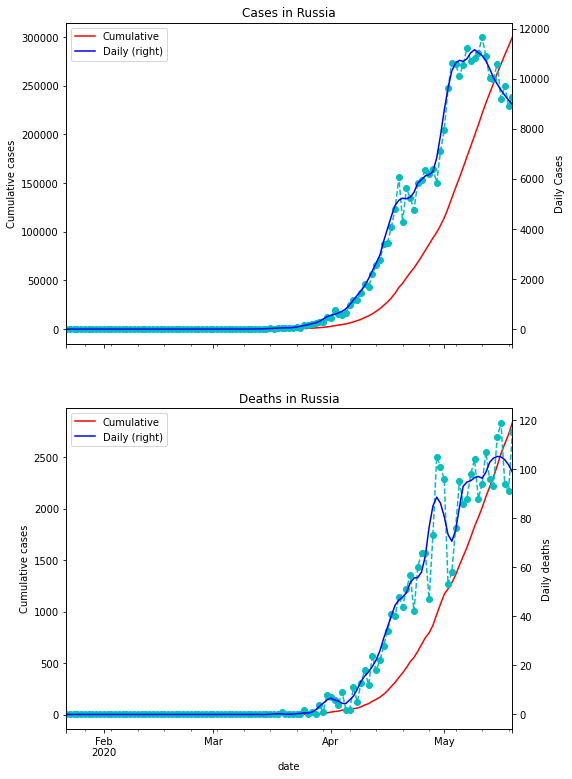

In [175]:
plot_daily(ru)

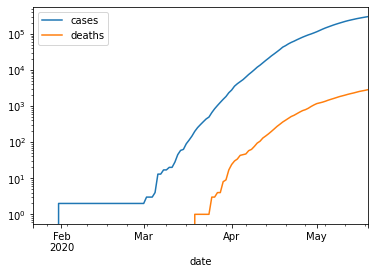

In [176]:
plot_data(ru[["cases", "deaths"]], logy=True)

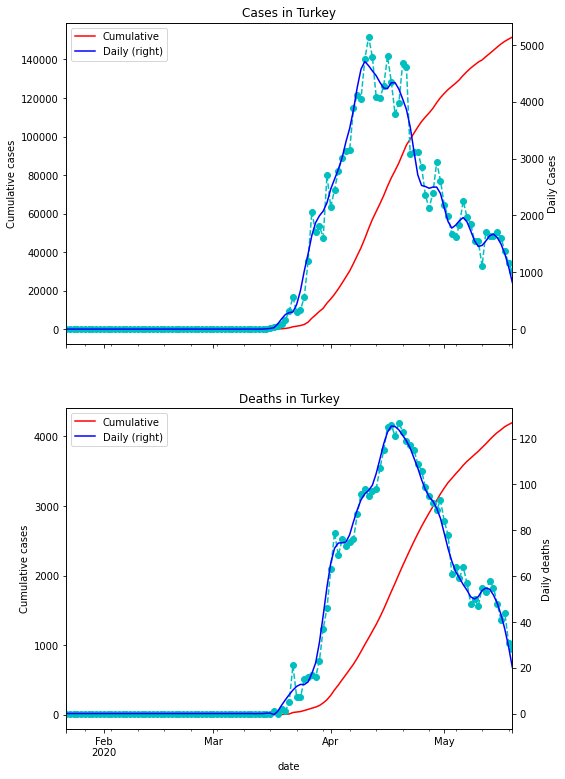

In [177]:
plot_daily(tu)

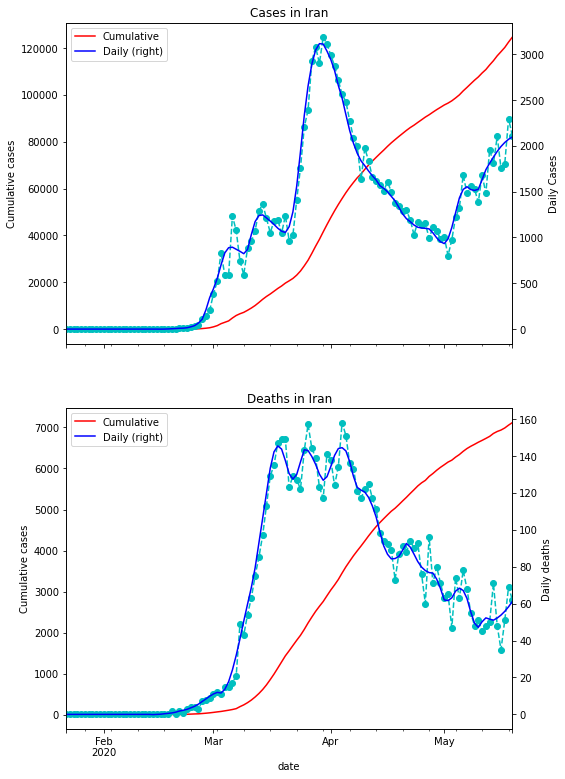

In [178]:
plot_daily(ir)

In [179]:
se.tail(10)

,,cases,deaths,daily_cases,daily_cases_s,daily_death,daily_death_s
date,day_of_year,,,,,,
2020-05-10,131,26322,3225,401.0,495.977661,5.0,46.383450
2020-05-11,132,26670,3256,348.0,517.832945,31.0,56.985237
2020-05-12,133,27272,3313,602.0,561.927739,57.0,76.716006
2020-05-13,134,27909,3460,637.0,613.131119,147.0,92.661228
2020-05-14,135,28582,3529,673.0,615.837024,69.0,86.215423
2020-05-15,136,29207,3646,625.0,582.392385,117.0,76.988733
2020-05-16,137,29677,3674,470.0,516.450078,28.0,59.182789
2020-05-17,138,30143,3679,466.0,418.010101,5.0,32.797591
2020-05-18,139,30377,3698,234.0,287.072455,19.0,-2.166861


In [180]:
us.tail(15)

,,cases,deaths,daily_cases,daily_cases_s,daily_death,daily_death_s
date,day_of_year,,,,,,
2020-05-05,126,1204351,71064,23976.0,24758.793901,2142.0,1985.362859
2020-05-06,127,1229331,73455,24980.0,25794.846154,2391.0,2053.876457
2020-05-07,128,1257023,75662,27692.0,25844.032440,2207.0,1876.169580
2020-05-08,129,1283929,77180,26906.0,24869.217754,1518.0,1576.603147
2020-05-09,130,1309550,78795,25621.0,22747.466977,1615.0,1301.510878
2020-05-10,131,1329260,79526,19710.0,21201.615190,731.0,1239.247475
2020-05-11,132,1347881,80682,18621.0,20751.600233,1156.0,1370.069930
2020-05-12,133,1369376,82356,21495.0,21980.470862,1674.0,1573.862471
2020-05-13,134,1390406,84119,21030.0,23422.924437,1763.0,1673.984071
